# Download drifter data

In [45]:
using Dates
using NCDatasets
using PhysOcean
using CoastalCurrents
using DIVAnd_HFRadar
using OceanPlot
using DIVAnd
using PyPlot

In [23]:
include("common.jl")

In [24]:
dlon = dlat = 0.5
lonr = -12:dlon:22.
latr = 30:dlat:55.5

30.0:0.5:55.5

In [25]:
dlon = dlat = 0.25
lonr = -8:dlon:15.
latr = 32:dlat:45

32.0:0.25:45.0

In [26]:
timerange = [DateTime(2010,5,1),DateTime(2020,1,1)]

2-element Vector{DateTime}:
 2010-05-01T00:00:00
 2020-01-01T00:00:00

In [27]:
#lonr = [7.6, 12.2]
#latr = [42, 44.5]
timerange = [DateTime(2020,1,1),DateTime(2020,12,31)]
param = "NSCT"

"NSCT"

In [28]:
indexURLs = ["ftp://my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/index_history.txt"]

1-element Vector{String}:
 "ftp://my.cmems-du.eu/Core/INSIT" ⋯ 61 bytes ⋯ "_drifter_PT6H/index_history.txt"

In [29]:
datadir = expanduser("~/Data/Blue-Cloud-2026/drifter")
mkpath(datadir)
basedir = datadir

"/home/abarth/Data/Blue-Cloud-2026/drifter"

files = CMEMS.download(lonr,latr,timerange,param,username,password,basedir; indexURLs = indexURLs)

In [30]:
files = String[]
for (root, dirs, files2) in walkdir(basedir)
    for file in files2
        push!(files,joinpath(root, file)) # add path to files
    end
end

In [31]:
fname = files[1]

"/home/abarth/Data/Blue-Cloud-2026/drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/GL_TS_DC_114640_2100922.nc"

In [32]:
ds = NCDataset(joinpath(basedir,fname))

Dataset: /home/abarth/Data/Blue-Cloud-2026/drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/GL_TS_DC_114640_2100922.nc
Group: /

Dimensions
   TIME = 2795
   DEPTH = 2
   LATITUDE = 2795
   LONGITUDE = 2795
   POSITION = 2795

Variables
  TIME   (2795)
    Datatype:    DateTime (Float64)
    Dimensions:  TIME
    Attributes:
     long_name            = Time
     standard_name        = time
     units                = days since 1950-01-01T00:00:00Z
     valid_min            = 0.0
     valid_max            = 90000.0
     QC_indicator         = 1.0
     QC_procedure         = 1.0
     uncertainty          =  
     comment              =  
     axis                 = T

  TIME_QC   (2795)
    Datatype:    Union{Missing, Int8} (Int8)
    Dimensions:  TIME
    Attributes:
     _FillValue           = -128
     long_name            = quality flag
     conventions          = OceanSITES reference table 2
     valid_min          

In [33]:
lon,lat,z,time,u,v = CoastalCurrents.loaddata(files);

In [35]:
speed = @. sqrt(u^2 + v^2);

In [36]:
good = isfinite.(u) .&& isfinite.(time) .&& isfinite.(lon) .&& (lonr[1] .<= lon .<= lonr[end]) .&& (latr[1] .<= lat .<= latr[end]) .&& speed .< 0.5;

In [37]:
(lon,lat,z,time,u,v) = map(d -> d[good],(lon,lat,z,time,u,v));

@show length(lon)
using PyPlot
quiver(lon,lat,u,v)
rg(z)

In [38]:
bathname = expanduser("~/Data/DivaData/Global/gebco_30sec_4.nc")
bathisglobal = true

true

In [39]:
mask,(pm,pn),(xi,yi) = DIVAnd.domain(bathname,bathisglobal,lonr,latr)
hx, hy, h = DIVAnd.load_bath(bathname, bathisglobal, lonr, latr);

(-8.0:0.25:15.0, 32.0:0.25:45.0, [-449.4687500076917 -462.65624998644677 … 4892.187499992683 4611.156250189089; -460.21875005518194 -499.9374999547364 … 4864.499999975256 4745.687500076178; … ; -78.90624996480963 -108.18749998962777 … 23.500000049080366 -270.62499986175214; -36.96875001055135 -40.40624998921195 … -1465.6874999161669 -724.0781248938811])

In [41]:
label = DIVAnd.floodfill(mask)
mask = label .== 1;

pcolormesh(xi,yi,mask)

In [42]:
len = 50e3

50000.0

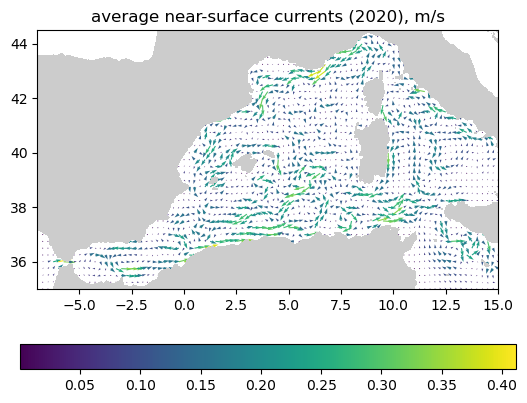

In [46]:
robs = vcat(u,v)
robs = Float64.(nomissing(robs,NaN))
directionobs = vcat(fill(90,size(u)), fill(0,size(v)))
epsilon2 = 0.1
residual = zeros(size(robs))
g = 9.81;
g = 0;
x = [lon; lon]
y = [lat; lat]
eps2_boundary_constraint = -1
eps2_div_constraint = -1
#eps2_boundary_constraint = 1e-9
eps2_div_constraint = 1e+1
#figure()
uri,vri,ηi = DIVAndrun_HFRadar(
    mask,h,(pm,pn),(xi,yi),(x,y),robs,directionobs,len,epsilon2;
    eps2_boundary_constraint = eps2_boundary_constraint,
    eps2_div_constraint = eps2_div_constraint,
    # eps2_Coriolis_constraint = -1,
    # f = 0.001,
    # residual = residual,
    # g = g,
    # ratio = 100,
    # lenη = (000.0, 000.0, 24 * 60 * 60. * 10),
    # maxit = 100000,
    # tol = 1e-6,
)
speedi = @. sqrt(uri^2 + vri^2)
clf(); quiver(xi,yi,uri,vri,speedi)
xlim(-7,15)
ylim(35.,44.5)
#colorbar(orientation="vertical")
colorbar(orientation="horizontal")
title("average near-surface currents (2020), m/s")
OceanPlot.set_aspect_ratio()
#OceanPlot.plot_coastline()
OceanPlot.plotmap()
savefig(expanduser("~/Figures/bluecloud-drifter-vel-div-$(eps2_div_constraint).png"))